In [1]:
import sys
sys.path.insert(0,'../..')

In [2]:
from numerical_integrators.singlestep import rk4
from numerical_integrators.adaptive_step import rkdp54

In [3]:
import multiprocessing as mp

In [4]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [5]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
%matplotlib inline

In [6]:
from numba import njit

In [7]:
A = 0.1
eps = 0.1
w = 2*np.pi/10

def vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    return np.pi*A*np.array([-np.sin(np.pi*f)*np.cos(np.pi*x.T[1]),np.cos(np.pi*f)*np.sin(np.pi*x.T[1])*dfdx]).T

def jac_vel(t,x):
    f = eps*np.sin(w*t)*x.T[0]**2 + (1-2*eps*np.sin(w*t))*x.T[0]
    dfdx = 2*eps*np.sin(w*t)*x.T[0]+ (1-2*eps*np.sin(w*t))
    d2fdx2 = 2*eps*np.sin(w*t)
    return np.pi*A*np.array([[-np.cos(np.pi*f)*np.pi*dfdx*np.cos(np.pi*x.T[1]),np.sin(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])],
                             [-np.sin(np.pi*f)*np.pi*dfdx*np.sin(np.pi*x.T[1])*dfdx + np.cos(np.pi*f)*np.pi*np.sin(np.pi*x.T[1])*d2fdx2,np.cos(np.pi*f)*np.pi*np.cos(np.pi*x.T[1])*dfdx]]).transpose(3,2,0,1)

In [8]:
xmin,xmax = 0,2
ymin,ymax = 0,1

nx = 1000
ny = 500

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)

In [9]:
def func(t,x,A=0.1,eps=0.1,w=2*np.pi/10):
    f = (eps*np.sin(w*t)*x[0]**2 + (1-2*eps*np.sin(w*t))*x[0])
    dfdx = (2*eps*np.sin(w*t)*x[0]+ (1-2*eps*np.sin(w*t)))
    d2fdx2 = 2*eps*np.sin(w*t)
    ret = np.empty(x.shape)
    ret[0] = np.pi*A*(-np.sin(np.pi*f)*np.cos(np.pi*x[1]))
    ret[1] = np.pi*A*(np.cos(np.pi*f)*np.sin(np.pi*x[1])*dfdx)
                          
                                                        
    ret[2] = np.pi*A*(-np.cos(np.pi*f)*np.pi*dfdx*np.cos(np.pi*x[1])*x[2] + np.sin(np.pi*f)*np.pi*np.sin(np.pi*x[1])*x[4])
    
    ret[3] = np.pi*A*(-np.cos(np.pi*f)*np.pi*dfdx*np.cos(np.pi*x[1])*x[3] + np.sin(np.pi*f)*np.pi*np.sin(np.pi*x[1])*x[5])
    
    ret[4] = np.pi*A*((-np.sin(np.pi*f)*np.pi*dfdx*np.sin(np.pi*x[1])*dfdx + np.cos(np.pi*f)*np.pi*np.sin(np.pi*x[1])*d2fdx2)*x[2] + np.cos(np.pi*f)*np.pi*np.cos(np.pi*x[1])*dfdx*x[4])
    
    ret[5] = np.pi*A*((-np.sin(np.pi*f)*np.pi*dfdx*np.sin(np.pi*x[1])*dfdx + np.cos(np.pi*f)*np.pi*np.sin(np.pi*x[1])*d2fdx2)*x[3] + np.cos(np.pi*f)*np.pi*np.cos(np.pi*x[1])*dfdx*x[5])
    return ret
    

In [10]:
def advect_part(t0,tf,pos,h,fun,integ,q,atol=None,rtol=None):
    t = np.ones((pos.shape[1:]))*t0
    h = np.ones((pos.shape[1:]))*h
    while np.any(np.less(t,tf)):
        h = np.minimum(h,tf-t)
        #print(np.max(t),np.min(t))
    #for j in range(np.ceil((tf-t0)/h).astype(int)):
        t,pos,h = integ(t,pos,h,fun,atol,rtol)
    q.put(pos)

In [11]:
def find_final_state(t0,tf,x,y,h,fun,integ,nproc=4,atol=None,rtol=None):
    grid = np.zeros((6,x.shape[0],y.shape[0]))
    grid[:2] = np.array(np.meshgrid(x,y,indexing='ij'))
    grid[2] = 1
    grid[5] = 1
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int)
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=advect_part, args=(t0,tf,grid[:,div[j]:div[j+1]],h,fun,integ,qs[j],atol,rtol)) for j in range(nproc)]
    for p in ps:
        p.start()
    for j,q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    [p.join() for p in ps]
    
    return grid[:2].transpose(1,2,0), grid[2:].transpose(1,2,0).reshape((x.shape[0],y.shape[0],2,2))

In [12]:
    grid = np.zeros((x.shape[0],y.shape[0],6))
    grid[...,:2] = np.array(np.meshgrid(x,y,indexing='ij')).transpose(1,2,0)
    grid[...,2] = 1
    grid[...,5] = 1

In [13]:
np.array(np.meshgrid(x,y,indexing='ij')).shape

(2, 1000, 500)

In [14]:
t0 = 0
tf = 20
h = 0.1
integ = rkdp54
#integ = rk4

fm, jac = find_final_state(t0,tf,x,y,h,func,integ,atol=1e-4,rtol=1e-4)

In [42]:
def get_evals_and_evecs(jac):
    u, s, v = np.linalg.svd(jac)
    
    lm1 = s[...,1]**2
    lm2 = s[...,0]**2
    
    xi1 = v[...,1]
    xi2 = v[...,0]
    
    #xi1 = v[...,1,:]
    #xi2 = v[...,0,:]
    
    return (lm1, lm2), (xi1, xi2)

In [43]:
(lm1,lm2),(xi1,xi2) = get_evals_and_evecs(jac)

In [44]:
xi2[10,10]

array([-0.53766686, -0.84315737])

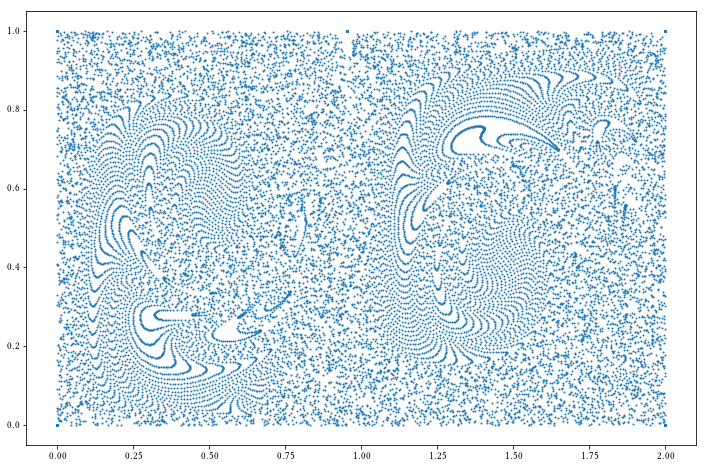

In [156]:
#fig = plt.figure(1,figsize=(12,8))
#plot = fig.add_subplot(111)
#plot.scatter(fm[...,0],fm[...,1],s=1)

/home/arne/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/arne/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


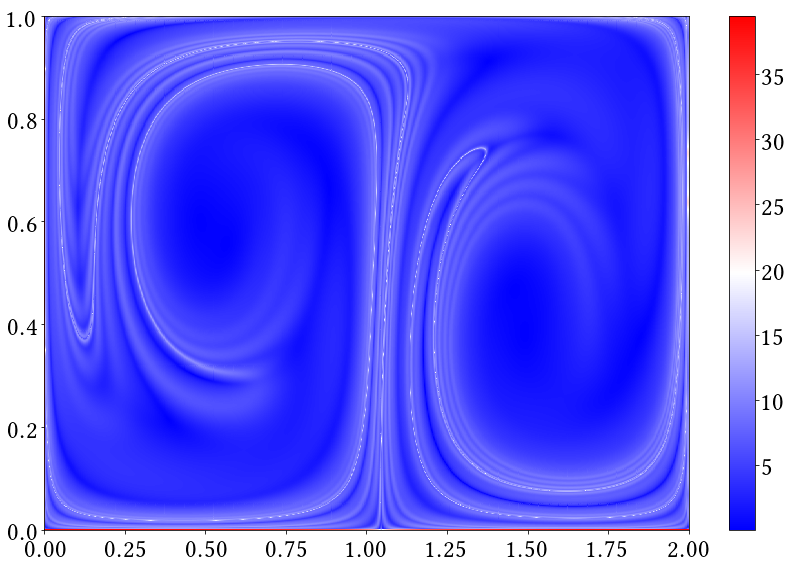

In [17]:
fig = plt.figure(1,figsize=(12,8))
plot = fig.add_subplot(111)
X,Y = np.meshgrid(x,y,indexing='ij')
msh=plot.pcolormesh(X,Y,np.log(lm2),cmap='bwr')
bar=plt.colorbar(msh)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
bar.ax.tick_params(labelsize=25)
plt.tight_layout()

In [23]:
def hess(lm,x,y):
    hess = np.empty((*lm.shape,2,2))
    grad = np.gradient(lm,x,y,edge_order=2)
    for k, grad_k in enumerate(grad):
        tmp_grad = np.gradient(grad_k,x,y,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hess[...,k,l] = grad_kl
    return hess
        #grad_ij = np.gradient(grad_cmp,x,y,edge_order=2)
        

In [24]:
hlm2 = hess(lm2,x,y)

In [35]:
A = np.logical_and(np.greater(lm2,1),np.greater(lm2,lm1))
B = np.less_equal(np.sum(xi2*np.sum(hlm2*xi2[...,np.newaxis],axis=2),axis=2),0)
AB = np.logical_and(A,B)

TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

/home/arne/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


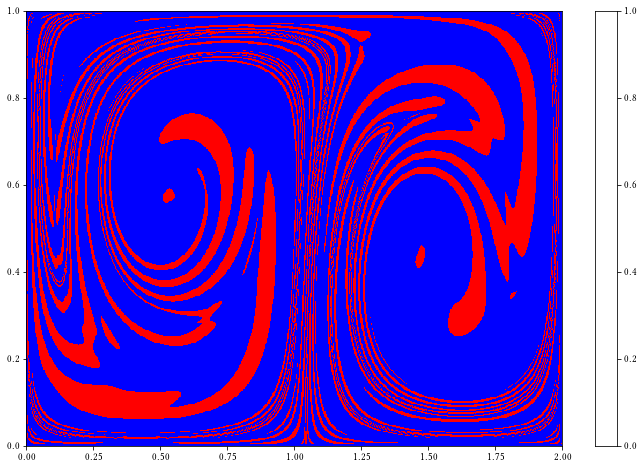

In [36]:
fig = plt.figure(1,figsize=(12,8))
plot = fig.add_subplot(111)
#X,Y = np.meshgrid(x,y,indexing='ij')
msh=plot.pcolormesh(x,y,AB.T,cmap='bwr')
bar=plt.colorbar(msh)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
bar.ax.tick_params(labelsize=25)
plt.tight_layout()

In [52]:
j2 = np.empty((x.shape[0]-2,y.shape[0]-2,2,2))

In [53]:
j2[...,0,0] = fm[2:,1:-1,0]-fm[:-2,1:-1,0]
j2[...,0,1] = fm[1:-1,2:,0]-fm[1:-1,:-2,0]
j2[...,1,0] = fm[2:,1:-1,1]-fm[:-2,1:-1,1]
j2[...,1,1] = fm[1:-1,2:,1]-fm[1:-1,:-2,1]

In [54]:
s2 = np.linalg.svd(j2,compute_uv=False)

In [56]:
np.min(s2[...,1])

7.500488802083247e-09

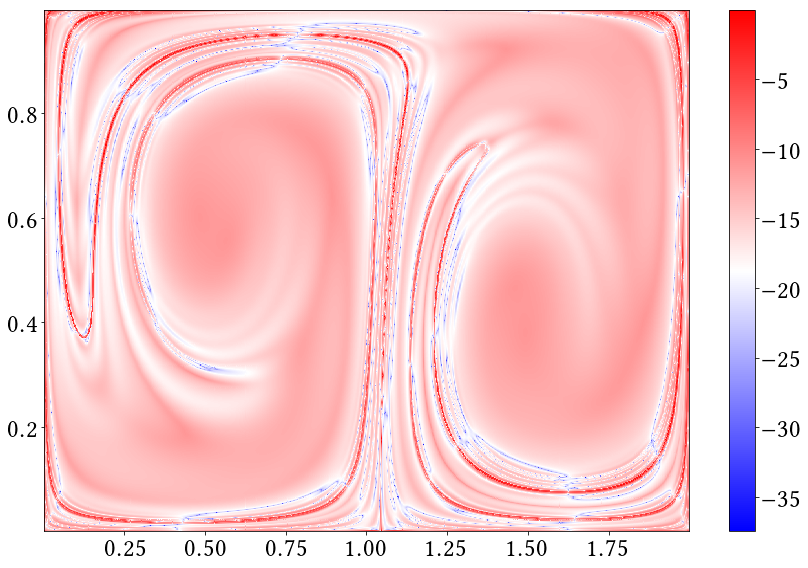

In [58]:
fig = plt.figure(1,figsize=(12,8))
plot = fig.add_subplot(111)
X,Y = np.meshgrid(x,y,indexing='ij')
msh=plot.pcolormesh(X[1:-1,1:-1],Y[1:-1,1:-1],np.log(s2[...,1]**2),cmap='bwr')
bar=plt.colorbar(msh)
plot.tick_params(axis='both', which='major', labelsize=25)
plot.tick_params(axis='both', which='minor', labelsize=10)
bar.ax.tick_params(labelsize=25)
plt.tight_layout()

In [63]:
np.max(lm1*lm2)

1.000134553202872

In [60]:
np.mean(s2[...,0]**2*s2[...,1]**2)

0.002776623872763494

In [ ]:
X,Y=np.meshgrid(x,y,indexing='ij')

In [41]:
def get_evecs(jac):
    u,s,v = np.linalg.svd(jac)
    
    xi2 = v[...,0]
    xi1 = v[...,1]
    
    return xi1, xi2

In [42]:
xi1, xi2 = get_evecs(jac)

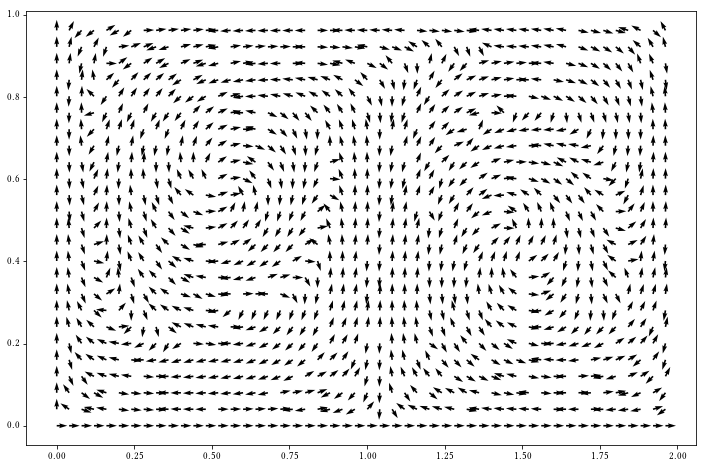

In [44]:
plt.figure(figsize=(12,8))
plt.quiver(X[::20,::20],Y[::20,::20],xi1[::20,::20,0],xi1[::20,::20,1])

In [32]:
xi1.shape

(2, 2, 500)